# WFSS Spectra Simulation for Contamination Correction

This notebook demonstrates basic techniques to simulate WFSS dispersed spectra, given source locations from an imaging mode exposure and a generalized World Coordinate System (gWCS) from an accompanying WFSS exposure.

Such simulations, when applied to all sources in the field, are crucial to estimate the contamination of overlapping spectra, as well as to mask dispersed spectral traces when trying to estimate the background.

This notebook builds on the simpler <a href="https://github.com/spacetelescope/jdat_notebooks/blob/main/notebooks/NIRCam/NIRCam_WFSS_Box_extraction/BoxExtraction_using_Grismconf_CRDS.ipynb">Box Extraction notebook</a> where we introduced the general concepts of spectral extraction as well as the <A HREF="https://github.com/npirzkal/GRISMCONF">GRISMCONF</A> module, which provides us with a low level interface to the gWCS model for WFSS modes.

The simulation method is relatively straight-foward and begins with an imaging mode exposure. 

* We first determine which pixels contain the source and the signal levels in those pixels.

* We then use the gWCS from the imaging mode file and also the WFSS observation to compute the corresponding location of each pixel in the frame of the WFSS observation. 

* Using the GRISMCONF functions and a wavelength vector, we next simulate the dispersion of the source. For each of the source pixels, we move through the wavelength vector and calculate the location where each wavelength value is dispersed to. We calculate the signal level associated with each wavelength position based on the flux of each input pixel in $F_{\lambda}$ units ($erg/s/cm^2/A$). 

* Since the calculated coordinates of the wavelength values will not, in general, align with the detector pixel grid, we use the <a href="https://github.com/spacetelescope/pypolyclip">Sutherland-Hodgman algorithm</A> to compute the fraction of each projected dispersed pixel that overlaps onto each detector pixel. Summing the signals from each 

Author: N. Pirzkal <br>
Date created: 12 December 2024

## Table of Contents
1. [Set CRDS Path and Server](#Set-CRDS-Path-and-Server)
2. [Package Imports](#Package-Imports)
3. [Define Functions and Parameters](#Define-Functions-and-Parameters)
4. [Download Data](#Download-Data)
5. [Run Pipeline Steps](#Run-Pipeline-Steps)
6. [Detect Sources](#Detect-Sources)
7. [Simulate spectrum of one source](#Simulate-spectrum-of-one-source)
      * [Locate source in imaging and WFSS data](#Locate-source-in-imaging-and-WFSS-data)
      * [Get wavelength information](#Get-wavelength-information)
      * [Simulate the dispersion of a single pixel](#Simulate-the-dispersion-of-a-single-pixel)
      * [Disperse all the pixels for our source](#Disperse-all-the-pixels-for-our-source)

## Set CRDS Path and Server

Before running the pipeline steps, we need to ensure our our CRDS environment is configured. This includes defining a CRDS cache directory in which to keep the reference files that will be used by the calibration pipeline.

If the root directory for the local CRDS cache has not already been set, it will be created in the home directory. This needs to be done before importing the crds package or any package that has crds as a dependency.

In [1]:
import os

In [2]:
# Check whether the local CRDS cache directory has been set.
# If not, set it to the user home directory
if (os.getenv('CRDS_PATH') is None):
    os.environ['CRDS_PATH'] = os.path.join(os.path.expanduser('~'), 'crds')
    
# Check whether the CRDS server URL has been set.  If not, set it.
if (os.getenv('CRDS_SERVER_URL') is None):
    os.environ['CRDS_SERVER_URL'] = 'https://jwst-crds.stsci.edu'

# Echo CRDS path and context in use
print('CRDS local filepath:', os.environ['CRDS_PATH'])
print('CRDS file server:', os.environ['CRDS_SERVER_URL'])

# Import crds after setting up the required environment variables
from crds import client
if client.get_crds_server() != os.environ['CRDS_SERVER_URL']:
    client.set_crds_server('https://jwst-crds.stsci.edu')

CRDS local filepath: /home/runner/crds
CRDS file server: https://jwst-crds.stsci.edu


## Package Imports

In [3]:
from astropy.convolution import convolve
from astropy.io import fits
from copy import deepcopy
import matplotlib.pyplot as plt
import numpy as np
import requests
from scipy.sparse import coo_matrix
import tqdm

import grismconf
from jwst import datamodels
from jwst.assign_wcs import AssignWcsStep
from jwst.flatfield import FlatFieldStep
from jwst.photom import PhotomStep
from photutils.background import Background2D, MedianBackground
from photutils.segmentation import make_2dgaussian_kernel
from photutils.segmentation import detect_sources
from pypolyclip import clip_multi

## Define Functions and Parameters

Define a function to download a named file via the MAST API to the current directory. The function includes authentication logic, but this example uses public data, so no MAST API token is required.

In [4]:
def get_jwst_file(name, mast_api_token=None, overwrite=False):
    """Retrieve a JWST data file from MAST archive.

    Parameters
    ----------
    name : str
        Name of the file to download from MAST
        
    mast_api_token : str
        MAST API token. Required only for proprietary data
        
    overwrite : bool
        If True and the requested file already exists locally, the file will not be downloaded. IF False,
        the file will be downloaded
"""
    # If the file already exists locally, don't redownload it, unless the
    # user has set the overwrite keyword
    if os.path.isfile(name):
        if not overwrite:
            print(f'{name} already exists locally. Skipping download.')
            return
        else:
            print(f'{name} exists locally. Re-downloading.')

    mast_url = "https://mast.stsci.edu/api/v0.1/Download/file"
    params = dict(uri=f"mast:JWST/product/{name}")
    if mast_api_token:
        headers = dict(Authorization=f"token {mast_api_token}")
    else:
        headers = {}
    r = requests.get(mast_url, params=params, headers=headers, stream=True)
    r.raise_for_status()
    with open(name, "wb") as fobj:
        for chunk in r.iter_content(chunk_size=1024000):
            fobj.write(chunk)
    if os.path.isfile(name):
        print(f"{name} successfully downloaded")

Define a function that will run assign_wcs and flat fielding on an input rate file

In [5]:
def run_pipeline_steps(filename):
    """Run the assign_wcs, flat field, and photom calibration steps on the given file.
    If the file contains WFSS data, trick the pipeline to use the imaging mode flat
    field reference file.
    
    Parameters
    ----------
    filename : str
        Name of the input file upon which the steps will be run
        
    Returns
    -------
    filename : str
        Name of the output file saved by the pipeline steps
        
    photom : jwst.datamodels.ImageModel
        Datamodel instance containing the calibrated data
    """
    assign_wcs = AssignWcsStep.call(filename)

    # In order to apply the imaging mode flat field reference file to the data,
    # we need to trick CRDS by temporarily changing the pupil value to be CLEAR
    reset_pupil = False
    if 'GRISM' in assign_wcs.meta.instrument.pupil:
        true_pupil = deepcopy(assign_wcs.meta.instrument.pupil)
        assign_wcs.meta.instrument.pupil = 'CLEAR'
        reset_pupil = True

    # Run the flat field step
    flat = FlatFieldStep.call(assign_wcs, save_results=True)

    # Run the photom step to populate the name of the WFSS sensitivity 
    photom = PhotomStep.call(flat, save_results=True)

    # Set the pupil back to the original value now that flat fielding is complete
    if reset_pupil:
        photom.meta.instrument.pupil = true_pupil
        photom.save(photom.meta.filename)
    
    # Return the name of the output file, as well as the datamodel
    return photom.meta.filename, photom

In [6]:
def show_2d_spec(data, xlim=(200, 240), ylim=(1705, 1730), vmin=0, vmax=3):
    """Show a 2D image with colorbar. Designed to display the 2D real and
    simulated spectra

    Parameters
    ----------
    data : numpy.ndimage
        2D image
    xlim : tup
        2-tuple of beginning and ending x-coordinates for the display
    ylim : tup
        2-tuple of beginning and ending y-coordinates for the display
    vmin : float
        Signal corresponding to minimum display scale
    vmax : float
        Signal corresponding to maximum display scale
    """
    fig, ax = plt.subplots(1, 1, figsize=(15, 3))
    cax = ax.imshow(data, origin="lower", aspect='auto', cmap='viridis', vmin=vmin, vmax=vmax)
    ax.set_xlim(xlim[0], xlim[1])  # change to (0, 700) to see the entire spectrum)
    ax.set_ylim(ylim[0], ylim[1])
    plt.xticks(range(xlim[0], xlim[1], 5))
    plt.xlabel("Dispersion coordinate (pixel)")
    plt.ylabel("Cross dispersion coordinate (pixel)")
    colorbar = fig.colorbar(cax, orientation='vertical', pad=0.01)
    colorbar.ax.set_ylabel('Signal', labelpad=10, rotation=270)

## Download Data

We start with a simple pair of imaging and wfss files. These were manually selected and point at the same field on the sky, and use the same NIRCam module, channel, and cross filter.

In [7]:
# First, download the imaging and WFSS files from MAST
imaging_file = "jw01076109001_02102_00001_nrcalong_cal.fits"
wfss_file = "jw01076109001_02101_00001_nrcalong_rate.fits"
get_jwst_file(imaging_file)
get_jwst_file(wfss_file)

jw01076109001_02102_00001_nrcalong_cal.fits successfully downloaded


jw01076109001_02101_00001_nrcalong_rate.fits successfully downloaded


## Run Pipeline Steps

We want to assign a WCS, apply a flat-field, and flux calibrate the WFSS data. For this, we use the run_pipeline_steps() function defined above. This will call the appropriate pipeline steps. We apply the imaging mode flat field to the WFSS file since the flat fields are not wavelength dependent.

In [8]:
# Run AssignWcsStep, FlatFieldStep, and PhotomStep on the WFSS rate file
wfss_file, wfss_data = run_pipeline_steps(wfss_file)

# Extract the WFSS pixel data from the datamodel instance
wfss_data = wfss_data.data

2025-05-15 18:59:02,034 - CRDS - INFO -  Calibration SW Found: jwst 1.18.0 (/opt/hostedtoolcache/Python/3.11.12/x64/lib/python3.11/site-packages/jwst-1.18.0.dist-info)


2025-05-15 18:59:02,328 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_system_datalvl_0002.rmap      694 bytes  (1 / 204 files) (0 / 741.0 K bytes)


2025-05-15 18:59:02,418 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_system_calver_0048.rmap    5.3 K bytes  (2 / 204 files) (694 / 741.0 K bytes)


2025-05-15 18:59:02,506 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_system_0047.imap        385 bytes  (3 / 204 files) (6.0 K / 741.0 K bytes)


2025-05-15 18:59:02,599 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_nirspec_wavelengthrange_0024.rmap    1.4 K bytes  (4 / 204 files) (6.4 K / 741.0 K bytes)


2025-05-15 18:59:02,723 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_nirspec_wavecorr_0005.rmap      884 bytes  (5 / 204 files) (7.8 K / 741.0 K bytes)


2025-05-15 18:59:02,843 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_nirspec_superbias_0079.rmap   36.0 K bytes  (6 / 204 files) (8.6 K / 741.0 K bytes)


2025-05-15 18:59:02,956 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_nirspec_sirskernel_0001.rmap      630 bytes  (7 / 204 files) (44.6 K / 741.0 K bytes)


2025-05-15 18:59:03,035 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_nirspec_sflat_0026.rmap   20.6 K bytes  (8 / 204 files) (45.3 K / 741.0 K bytes)


2025-05-15 18:59:03,135 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_nirspec_saturation_0018.rmap    2.0 K bytes  (9 / 204 files) (65.9 K / 741.0 K bytes)


2025-05-15 18:59:03,212 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_nirspec_refpix_0015.rmap    1.6 K bytes  (10 / 204 files) (67.9 K / 741.0 K bytes)


2025-05-15 18:59:03,299 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_nirspec_readnoise_0025.rmap    2.6 K bytes  (11 / 204 files) (69.5 K / 741.0 K bytes)


2025-05-15 18:59:03,388 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_nirspec_pictureframe_0001.rmap      675 bytes  (12 / 204 files) (72.0 K / 741.0 K bytes)


2025-05-15 18:59:03,486 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_nirspec_photom_0013.rmap      958 bytes  (13 / 204 files) (72.7 K / 741.0 K bytes)


2025-05-15 18:59:03,574 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_nirspec_pathloss_0008.rmap    1.2 K bytes  (14 / 204 files) (73.7 K / 741.0 K bytes)


2025-05-15 18:59:03,698 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_nirspec_pars-whitelightstep_0001.rmap      777 bytes  (15 / 204 files) (74.9 K / 741.0 K bytes)


2025-05-15 18:59:03,797 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_nirspec_pars-spec2pipeline_0013.rmap    2.1 K bytes  (16 / 204 files) (75.6 K / 741.0 K bytes)


2025-05-15 18:59:03,888 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_nirspec_pars-resamplespecstep_0002.rmap      709 bytes  (17 / 204 files) (77.8 K / 741.0 K bytes)


2025-05-15 18:59:03,963 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_nirspec_pars-outlierdetectionstep_0005.rmap    1.1 K bytes  (18 / 204 files) (78.5 K / 741.0 K bytes)


2025-05-15 18:59:04,041 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_nirspec_pars-jumpstep_0005.rmap      810 bytes  (19 / 204 files) (79.6 K / 741.0 K bytes)


2025-05-15 18:59:04,143 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_nirspec_pars-image2pipeline_0008.rmap    1.0 K bytes  (20 / 204 files) (80.4 K / 741.0 K bytes)


2025-05-15 18:59:04,223 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_nirspec_pars-detector1pipeline_0003.rmap    1.1 K bytes  (21 / 204 files) (81.4 K / 741.0 K bytes)


2025-05-15 18:59:04,416 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_nirspec_pars-darkpipeline_0003.rmap      872 bytes  (22 / 204 files) (82.5 K / 741.0 K bytes)


2025-05-15 18:59:04,529 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_nirspec_pars-darkcurrentstep_0003.rmap    1.8 K bytes  (23 / 204 files) (83.4 K / 741.0 K bytes)


2025-05-15 18:59:04,625 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_nirspec_ote_0030.rmap    1.3 K bytes  (24 / 204 files) (85.2 K / 741.0 K bytes)


2025-05-15 18:59:04,705 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_nirspec_msaoper_0016.rmap    1.5 K bytes  (25 / 204 files) (86.4 K / 741.0 K bytes)


2025-05-15 18:59:04,782 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_nirspec_msa_0027.rmap    1.3 K bytes  (26 / 204 files) (87.9 K / 741.0 K bytes)


2025-05-15 18:59:04,864 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_nirspec_mask_0043.rmap    3.5 K bytes  (27 / 204 files) (89.2 K / 741.0 K bytes)


2025-05-15 18:59:05,042 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_nirspec_linearity_0017.rmap    1.6 K bytes  (28 / 204 files) (92.7 K / 741.0 K bytes)


2025-05-15 18:59:05,117 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_nirspec_ipc_0006.rmap      876 bytes  (29 / 204 files) (94.3 K / 741.0 K bytes)


2025-05-15 18:59:05,197 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_nirspec_ifuslicer_0017.rmap    1.5 K bytes  (30 / 204 files) (95.2 K / 741.0 K bytes)


2025-05-15 18:59:05,286 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_nirspec_ifupost_0019.rmap    1.5 K bytes  (31 / 204 files) (96.7 K / 741.0 K bytes)


2025-05-15 18:59:05,356 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_nirspec_ifufore_0017.rmap    1.5 K bytes  (32 / 204 files) (98.2 K / 741.0 K bytes)


2025-05-15 18:59:05,432 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_nirspec_gain_0023.rmap    1.8 K bytes  (33 / 204 files) (99.7 K / 741.0 K bytes)


2025-05-15 18:59:05,508 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_nirspec_fpa_0028.rmap    1.3 K bytes  (34 / 204 files) (101.5 K / 741.0 K bytes)


2025-05-15 18:59:05,613 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_nirspec_fore_0026.rmap    5.0 K bytes  (35 / 204 files) (102.7 K / 741.0 K bytes)


2025-05-15 18:59:05,684 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_nirspec_flat_0015.rmap    3.8 K bytes  (36 / 204 files) (107.7 K / 741.0 K bytes)


2025-05-15 18:59:05,757 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_nirspec_fflat_0026.rmap    7.2 K bytes  (37 / 204 files) (111.5 K / 741.0 K bytes)


2025-05-15 18:59:05,869 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_nirspec_extract1d_0018.rmap    2.3 K bytes  (38 / 204 files) (118.7 K / 741.0 K bytes)


2025-05-15 18:59:05,953 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_nirspec_disperser_0028.rmap    5.7 K bytes  (39 / 204 files) (121.0 K / 741.0 K bytes)


2025-05-15 18:59:06,041 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_nirspec_dflat_0007.rmap    1.1 K bytes  (40 / 204 files) (126.7 K / 741.0 K bytes)


2025-05-15 18:59:06,136 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_nirspec_dark_0074.rmap   34.2 K bytes  (41 / 204 files) (127.9 K / 741.0 K bytes)


2025-05-15 18:59:06,227 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_nirspec_cubepar_0015.rmap      966 bytes  (42 / 204 files) (162.1 K / 741.0 K bytes)


2025-05-15 18:59:06,302 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_nirspec_collimator_0026.rmap    1.3 K bytes  (43 / 204 files) (163.1 K / 741.0 K bytes)


2025-05-15 18:59:06,428 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_nirspec_camera_0026.rmap    1.3 K bytes  (44 / 204 files) (164.4 K / 741.0 K bytes)


2025-05-15 18:59:06,521 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_nirspec_barshadow_0007.rmap    1.8 K bytes  (45 / 204 files) (165.7 K / 741.0 K bytes)


2025-05-15 18:59:06,591 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_nirspec_area_0018.rmap    6.3 K bytes  (46 / 204 files) (167.5 K / 741.0 K bytes)


2025-05-15 18:59:06,665 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_nirspec_apcorr_0009.rmap    5.6 K bytes  (47 / 204 files) (173.8 K / 741.0 K bytes)


2025-05-15 18:59:06,766 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_nirspec_0398.imap     5.8 K bytes  (48 / 204 files) (179.3 K / 741.0 K bytes)


2025-05-15 18:59:06,870 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_niriss_wfssbkg_0010.rmap    3.1 K bytes  (49 / 204 files) (185.1 K / 741.0 K bytes)


2025-05-15 18:59:06,973 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_niriss_wavelengthrange_0006.rmap      862 bytes  (50 / 204 files) (188.2 K / 741.0 K bytes)


2025-05-15 18:59:07,060 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_niriss_trappars_0004.rmap      753 bytes  (51 / 204 files) (189.1 K / 741.0 K bytes)


2025-05-15 18:59:07,135 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_niriss_trapdensity_0005.rmap      705 bytes  (52 / 204 files) (189.9 K / 741.0 K bytes)


2025-05-15 18:59:07,212 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_niriss_throughput_0005.rmap    1.3 K bytes  (53 / 204 files) (190.6 K / 741.0 K bytes)


2025-05-15 18:59:07,287 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_niriss_superbias_0030.rmap    7.4 K bytes  (54 / 204 files) (191.8 K / 741.0 K bytes)


2025-05-15 18:59:07,357 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_niriss_specwcs_0014.rmap    3.1 K bytes  (55 / 204 files) (199.2 K / 741.0 K bytes)


2025-05-15 18:59:07,431 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_niriss_specprofile_0008.rmap    2.4 K bytes  (56 / 204 files) (202.4 K / 741.0 K bytes)


2025-05-15 18:59:07,624 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_niriss_speckernel_0006.rmap    1.0 K bytes  (57 / 204 files) (204.7 K / 741.0 K bytes)


2025-05-15 18:59:07,724 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_niriss_sirskernel_0001.rmap      627 bytes  (58 / 204 files) (205.8 K / 741.0 K bytes)


2025-05-15 18:59:07,833 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_niriss_saturation_0015.rmap      829 bytes  (59 / 204 files) (206.4 K / 741.0 K bytes)


2025-05-15 18:59:07,906 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_niriss_readnoise_0011.rmap      987 bytes  (60 / 204 files) (207.2 K / 741.0 K bytes)


2025-05-15 18:59:08,012 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_niriss_photom_0036.rmap    1.3 K bytes  (61 / 204 files) (208.2 K / 741.0 K bytes)


2025-05-15 18:59:08,090 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_niriss_persat_0007.rmap      674 bytes  (62 / 204 files) (209.5 K / 741.0 K bytes)


2025-05-15 18:59:08,169 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_niriss_pathloss_0003.rmap      758 bytes  (63 / 204 files) (210.1 K / 741.0 K bytes)


2025-05-15 18:59:08,248 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_niriss_pastasoss_0004.rmap      818 bytes  (64 / 204 files) (210.9 K / 741.0 K bytes)


2025-05-15 18:59:08,326 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_niriss_pars-undersamplecorrectionstep_0001.rmap      904 bytes  (65 / 204 files) (211.7 K / 741.0 K bytes)


2025-05-15 18:59:08,402 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_niriss_pars-tweakregstep_0012.rmap    3.1 K bytes  (66 / 204 files) (212.6 K / 741.0 K bytes)


2025-05-15 18:59:08,477 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_niriss_pars-spec2pipeline_0008.rmap      984 bytes  (67 / 204 files) (215.8 K / 741.0 K bytes)


2025-05-15 18:59:08,575 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_niriss_pars-sourcecatalogstep_0002.rmap    2.3 K bytes  (68 / 204 files) (216.7 K / 741.0 K bytes)


2025-05-15 18:59:08,654 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_niriss_pars-resamplestep_0002.rmap      687 bytes  (69 / 204 files) (219.1 K / 741.0 K bytes)


2025-05-15 18:59:08,733 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_niriss_pars-outlierdetectionstep_0004.rmap    2.7 K bytes  (70 / 204 files) (219.7 K / 741.0 K bytes)


2025-05-15 18:59:08,813 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_niriss_pars-jumpstep_0007.rmap    6.4 K bytes  (71 / 204 files) (222.4 K / 741.0 K bytes)


2025-05-15 18:59:08,899 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_niriss_pars-image2pipeline_0005.rmap    1.0 K bytes  (72 / 204 files) (228.8 K / 741.0 K bytes)


2025-05-15 18:59:08,986 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_niriss_pars-detector1pipeline_0002.rmap    1.0 K bytes  (73 / 204 files) (229.8 K / 741.0 K bytes)


2025-05-15 18:59:09,064 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_niriss_pars-darkpipeline_0002.rmap      868 bytes  (74 / 204 files) (230.8 K / 741.0 K bytes)


2025-05-15 18:59:09,138 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_niriss_pars-darkcurrentstep_0001.rmap      591 bytes  (75 / 204 files) (231.7 K / 741.0 K bytes)


2025-05-15 18:59:09,213 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_niriss_pars-chargemigrationstep_0004.rmap    5.7 K bytes  (76 / 204 files) (232.3 K / 741.0 K bytes)


2025-05-15 18:59:09,288 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_niriss_nrm_0005.rmap      663 bytes  (77 / 204 files) (237.9 K / 741.0 K bytes)


2025-05-15 18:59:09,371 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_niriss_mask_0022.rmap    1.3 K bytes  (78 / 204 files) (238.6 K / 741.0 K bytes)


2025-05-15 18:59:09,448 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_niriss_linearity_0022.rmap      961 bytes  (79 / 204 files) (239.9 K / 741.0 K bytes)


2025-05-15 18:59:09,521 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_niriss_ipc_0007.rmap      651 bytes  (80 / 204 files) (240.9 K / 741.0 K bytes)


2025-05-15 18:59:09,611 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_niriss_gain_0011.rmap      797 bytes  (81 / 204 files) (241.5 K / 741.0 K bytes)


2025-05-15 18:59:09,684 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_niriss_flat_0023.rmap    5.9 K bytes  (82 / 204 files) (242.3 K / 741.0 K bytes)


2025-05-15 18:59:09,757 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_niriss_filteroffset_0010.rmap      853 bytes  (83 / 204 files) (248.2 K / 741.0 K bytes)


2025-05-15 18:59:09,830 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_niriss_extract1d_0007.rmap      905 bytes  (84 / 204 files) (249.0 K / 741.0 K bytes)


2025-05-15 18:59:09,903 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_niriss_drizpars_0004.rmap      519 bytes  (85 / 204 files) (249.9 K / 741.0 K bytes)


2025-05-15 18:59:09,982 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_niriss_distortion_0025.rmap    3.4 K bytes  (86 / 204 files) (250.4 K / 741.0 K bytes)


2025-05-15 18:59:10,066 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_niriss_dark_0034.rmap    7.5 K bytes  (87 / 204 files) (253.9 K / 741.0 K bytes)


2025-05-15 18:59:10,148 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_niriss_bkg_0002.rmap    2.9 K bytes  (88 / 204 files) (261.4 K / 741.0 K bytes)


2025-05-15 18:59:10,227 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_niriss_area_0014.rmap    2.7 K bytes  (89 / 204 files) (264.3 K / 741.0 K bytes)


2025-05-15 18:59:10,304 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_niriss_apcorr_0010.rmap    4.3 K bytes  (90 / 204 files) (267.0 K / 741.0 K bytes)


2025-05-15 18:59:10,387 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_niriss_abvegaoffset_0004.rmap    1.4 K bytes  (91 / 204 files) (271.3 K / 741.0 K bytes)


2025-05-15 18:59:10,471 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_niriss_0272.imap      5.8 K bytes  (92 / 204 files) (272.7 K / 741.0 K bytes)


2025-05-15 18:59:10,548 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_nircam_wfssbkg_0004.rmap    7.2 K bytes  (93 / 204 files) (278.5 K / 741.0 K bytes)


2025-05-15 18:59:10,621 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_nircam_wavelengthrange_0010.rmap      996 bytes  (94 / 204 files) (285.7 K / 741.0 K bytes)


2025-05-15 18:59:10,710 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_nircam_tsophot_0003.rmap      896 bytes  (95 / 204 files) (286.7 K / 741.0 K bytes)


2025-05-15 18:59:10,780 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_nircam_trappars_0003.rmap    1.6 K bytes  (96 / 204 files) (287.6 K / 741.0 K bytes)


2025-05-15 18:59:10,861 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_nircam_trapdensity_0003.rmap    1.6 K bytes  (97 / 204 files) (289.2 K / 741.0 K bytes)


2025-05-15 18:59:10,934 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_nircam_superbias_0019.rmap   18.9 K bytes  (98 / 204 files) (290.8 K / 741.0 K bytes)


2025-05-15 18:59:11,019 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_nircam_specwcs_0022.rmap    7.1 K bytes  (99 / 204 files) (309.7 K / 741.0 K bytes)


2025-05-15 18:59:11,102 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_nircam_sirskernel_0002.rmap      671 bytes  (100 / 204 files) (316.8 K / 741.0 K bytes)


2025-05-15 18:59:11,176 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_nircam_saturation_0011.rmap    2.8 K bytes  (101 / 204 files) (317.5 K / 741.0 K bytes)


2025-05-15 18:59:11,265 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_nircam_readnoise_0026.rmap   25.9 K bytes  (102 / 204 files) (320.3 K / 741.0 K bytes)


2025-05-15 18:59:11,365 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_nircam_psfmask_0008.rmap   28.4 K bytes  (103 / 204 files) (346.2 K / 741.0 K bytes)


2025-05-15 18:59:11,459 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_nircam_photom_0028.rmap    3.4 K bytes  (104 / 204 files) (374.6 K / 741.0 K bytes)


2025-05-15 18:59:11,578 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_nircam_persat_0005.rmap    1.6 K bytes  (105 / 204 files) (377.9 K / 741.0 K bytes)


2025-05-15 18:59:11,665 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_nircam_pars-whitelightstep_0004.rmap    2.0 K bytes  (106 / 204 files) (379.5 K / 741.0 K bytes)


2025-05-15 18:59:11,738 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_nircam_pars-tweakregstep_0003.rmap    4.5 K bytes  (107 / 204 files) (381.5 K / 741.0 K bytes)


2025-05-15 18:59:11,814 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_nircam_pars-spec2pipeline_0008.rmap      984 bytes  (108 / 204 files) (386.0 K / 741.0 K bytes)


2025-05-15 18:59:11,896 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_nircam_pars-sourcecatalogstep_0002.rmap    4.6 K bytes  (109 / 204 files) (387.0 K / 741.0 K bytes)


2025-05-15 18:59:11,982 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_nircam_pars-resamplestep_0002.rmap      687 bytes  (110 / 204 files) (391.6 K / 741.0 K bytes)


2025-05-15 18:59:12,056 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_nircam_pars-outlierdetectionstep_0003.rmap      940 bytes  (111 / 204 files) (392.3 K / 741.0 K bytes)


2025-05-15 18:59:12,128 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_nircam_pars-jumpstep_0005.rmap      806 bytes  (112 / 204 files) (393.2 K / 741.0 K bytes)


2025-05-15 18:59:12,200 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_nircam_pars-image2pipeline_0004.rmap    1.1 K bytes  (113 / 204 files) (394.0 K / 741.0 K bytes)


2025-05-15 18:59:12,287 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_nircam_pars-detector1pipeline_0005.rmap    1.3 K bytes  (114 / 204 files) (395.2 K / 741.0 K bytes)


2025-05-15 18:59:12,381 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_nircam_pars-darkpipeline_0002.rmap      868 bytes  (115 / 204 files) (396.4 K / 741.0 K bytes)


2025-05-15 18:59:12,466 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_nircam_pars-darkcurrentstep_0001.rmap      618 bytes  (116 / 204 files) (397.3 K / 741.0 K bytes)


2025-05-15 18:59:12,542 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_nircam_mask_0012.rmap    4.1 K bytes  (117 / 204 files) (397.9 K / 741.0 K bytes)


2025-05-15 18:59:12,620 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_nircam_linearity_0011.rmap    2.4 K bytes  (118 / 204 files) (402.1 K / 741.0 K bytes)


2025-05-15 18:59:12,697 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_nircam_ipc_0003.rmap    2.0 K bytes  (119 / 204 files) (404.5 K / 741.0 K bytes)


2025-05-15 18:59:12,785 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_nircam_gain_0016.rmap    2.1 K bytes  (120 / 204 files) (406.4 K / 741.0 K bytes)


2025-05-15 18:59:12,873 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_nircam_flat_0028.rmap   51.7 K bytes  (121 / 204 files) (408.6 K / 741.0 K bytes)


2025-05-15 18:59:12,999 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_nircam_filteroffset_0004.rmap    1.4 K bytes  (122 / 204 files) (460.2 K / 741.0 K bytes)


2025-05-15 18:59:13,071 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_nircam_extract1d_0005.rmap    1.2 K bytes  (123 / 204 files) (461.7 K / 741.0 K bytes)


2025-05-15 18:59:13,162 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_nircam_drizpars_0001.rmap      519 bytes  (124 / 204 files) (462.9 K / 741.0 K bytes)


2025-05-15 18:59:13,239 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_nircam_distortion_0033.rmap   53.4 K bytes  (125 / 204 files) (463.4 K / 741.0 K bytes)


2025-05-15 18:59:13,361 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_nircam_dark_0047.rmap   29.0 K bytes  (126 / 204 files) (516.7 K / 741.0 K bytes)


2025-05-15 18:59:13,450 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_nircam_area_0012.rmap   33.5 K bytes  (127 / 204 files) (545.7 K / 741.0 K bytes)


2025-05-15 18:59:13,534 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_nircam_apcorr_0008.rmap    4.3 K bytes  (128 / 204 files) (579.2 K / 741.0 K bytes)


2025-05-15 18:59:13,617 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_nircam_abvegaoffset_0003.rmap    1.3 K bytes  (129 / 204 files) (583.5 K / 741.0 K bytes)


2025-05-15 18:59:13,688 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_nircam_0314.imap      5.6 K bytes  (130 / 204 files) (584.8 K / 741.0 K bytes)


2025-05-15 18:59:13,769 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_miri_wavelengthrange_0027.rmap      929 bytes  (131 / 204 files) (590.4 K / 741.0 K bytes)


2025-05-15 18:59:13,848 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_miri_tsophot_0004.rmap      882 bytes  (132 / 204 files) (591.3 K / 741.0 K bytes)


2025-05-15 18:59:13,931 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_miri_straymask_0009.rmap      987 bytes  (133 / 204 files) (592.2 K / 741.0 K bytes)


2025-05-15 18:59:14,010 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_miri_specwcs_0043.rmap    5.8 K bytes  (134 / 204 files) (593.2 K / 741.0 K bytes)


2025-05-15 18:59:14,091 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_miri_saturation_0015.rmap    1.2 K bytes  (135 / 204 files) (599.0 K / 741.0 K bytes)


2025-05-15 18:59:14,164 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_miri_rscd_0008.rmap    1.0 K bytes  (136 / 204 files) (600.1 K / 741.0 K bytes)


2025-05-15 18:59:14,252 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_miri_resol_0006.rmap      790 bytes  (137 / 204 files) (601.2 K / 741.0 K bytes)


2025-05-15 18:59:14,323 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_miri_reset_0026.rmap    3.9 K bytes  (138 / 204 files) (602.0 K / 741.0 K bytes)


2025-05-15 18:59:14,413 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_miri_regions_0034.rmap    5.2 K bytes  (139 / 204 files) (605.8 K / 741.0 K bytes)


2025-05-15 18:59:14,486 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_miri_readnoise_0023.rmap    1.6 K bytes  (140 / 204 files) (611.0 K / 741.0 K bytes)


2025-05-15 18:59:14,569 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_miri_psfmask_0009.rmap    2.1 K bytes  (141 / 204 files) (612.7 K / 741.0 K bytes)


2025-05-15 18:59:14,658 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_miri_psf_0003.rmap      839 bytes  (142 / 204 files) (614.8 K / 741.0 K bytes)


2025-05-15 18:59:14,730 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_miri_photom_0056.rmap    3.7 K bytes  (143 / 204 files) (615.6 K / 741.0 K bytes)


2025-05-15 18:59:14,805 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_miri_pathloss_0005.rmap      866 bytes  (144 / 204 files) (619.4 K / 741.0 K bytes)


2025-05-15 18:59:14,888 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_miri_pars-whitelightstep_0003.rmap      912 bytes  (145 / 204 files) (620.2 K / 741.0 K bytes)


2025-05-15 18:59:14,971 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_miri_pars-tweakregstep_0003.rmap    1.8 K bytes  (146 / 204 files) (621.2 K / 741.0 K bytes)


2025-05-15 18:59:15,054 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_miri_pars-spec3pipeline_0009.rmap      816 bytes  (147 / 204 files) (623.0 K / 741.0 K bytes)


2025-05-15 18:59:15,127 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_miri_pars-spec2pipeline_0012.rmap    1.3 K bytes  (148 / 204 files) (623.8 K / 741.0 K bytes)


2025-05-15 18:59:15,203 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_miri_pars-sourcecatalogstep_0003.rmap    1.9 K bytes  (149 / 204 files) (625.1 K / 741.0 K bytes)


2025-05-15 18:59:15,297 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_miri_pars-resamplestep_0002.rmap      677 bytes  (150 / 204 files) (627.0 K / 741.0 K bytes)


2025-05-15 18:59:15,397 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_miri_pars-resamplespecstep_0002.rmap      706 bytes  (151 / 204 files) (627.7 K / 741.0 K bytes)


2025-05-15 18:59:15,474 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_miri_pars-outlierdetectionstep_0020.rmap    3.4 K bytes  (152 / 204 files) (628.4 K / 741.0 K bytes)


2025-05-15 18:59:15,558 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_miri_pars-jumpstep_0011.rmap    1.6 K bytes  (153 / 204 files) (631.8 K / 741.0 K bytes)


2025-05-15 18:59:15,629 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_miri_pars-image2pipeline_0010.rmap    1.1 K bytes  (154 / 204 files) (633.4 K / 741.0 K bytes)


2025-05-15 18:59:15,717 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_miri_pars-extract1dstep_0003.rmap      807 bytes  (155 / 204 files) (634.5 K / 741.0 K bytes)


2025-05-15 18:59:15,787 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_miri_pars-emicorrstep_0003.rmap      796 bytes  (156 / 204 files) (635.3 K / 741.0 K bytes)


2025-05-15 18:59:15,877 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_miri_pars-detector1pipeline_0010.rmap    1.6 K bytes  (157 / 204 files) (636.1 K / 741.0 K bytes)


2025-05-15 18:59:15,970 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_miri_pars-darkpipeline_0002.rmap      860 bytes  (158 / 204 files) (637.7 K / 741.0 K bytes)


2025-05-15 18:59:16,054 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_miri_pars-darkcurrentstep_0002.rmap      683 bytes  (159 / 204 files) (638.5 K / 741.0 K bytes)


2025-05-15 18:59:16,125 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_miri_mrsxartcorr_0002.rmap    2.2 K bytes  (160 / 204 files) (639.2 K / 741.0 K bytes)


2025-05-15 18:59:16,199 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_miri_mrsptcorr_0005.rmap    2.0 K bytes  (161 / 204 files) (641.4 K / 741.0 K bytes)


2025-05-15 18:59:16,269 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_miri_mask_0026.rmap    4.3 K bytes  (162 / 204 files) (643.3 K / 741.0 K bytes)


2025-05-15 18:59:16,356 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_miri_linearity_0018.rmap    2.8 K bytes  (163 / 204 files) (647.6 K / 741.0 K bytes)


2025-05-15 18:59:16,445 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_miri_ipc_0008.rmap      700 bytes  (164 / 204 files) (650.4 K / 741.0 K bytes)


2025-05-15 18:59:16,517 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_miri_gain_0013.rmap    3.9 K bytes  (165 / 204 files) (651.1 K / 741.0 K bytes)


2025-05-15 18:59:16,608 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_miri_fringefreq_0003.rmap    1.4 K bytes  (166 / 204 files) (655.0 K / 741.0 K bytes)


2025-05-15 18:59:16,690 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_miri_fringe_0019.rmap    3.9 K bytes  (167 / 204 files) (656.5 K / 741.0 K bytes)


2025-05-15 18:59:16,765 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_miri_flat_0066.rmap   15.7 K bytes  (168 / 204 files) (660.4 K / 741.0 K bytes)


2025-05-15 18:59:16,846 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_miri_filteroffset_0025.rmap    2.5 K bytes  (169 / 204 files) (676.1 K / 741.0 K bytes)


2025-05-15 18:59:16,936 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_miri_extract1d_0020.rmap    1.4 K bytes  (170 / 204 files) (678.6 K / 741.0 K bytes)


2025-05-15 18:59:17,033 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_miri_emicorr_0003.rmap      663 bytes  (171 / 204 files) (679.9 K / 741.0 K bytes)


2025-05-15 18:59:17,184 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_miri_drizpars_0002.rmap      511 bytes  (172 / 204 files) (680.6 K / 741.0 K bytes)


2025-05-15 18:59:17,270 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_miri_distortion_0040.rmap    4.9 K bytes  (173 / 204 files) (681.1 K / 741.0 K bytes)


2025-05-15 18:59:17,356 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_miri_dark_0036.rmap    4.4 K bytes  (174 / 204 files) (686.0 K / 741.0 K bytes)


2025-05-15 18:59:17,442 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_miri_cubepar_0017.rmap      800 bytes  (175 / 204 files) (690.4 K / 741.0 K bytes)


2025-05-15 18:59:17,520 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_miri_area_0015.rmap      866 bytes  (176 / 204 files) (691.2 K / 741.0 K bytes)


2025-05-15 18:59:17,613 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_miri_apcorr_0019.rmap    5.0 K bytes  (177 / 204 files) (692.0 K / 741.0 K bytes)


2025-05-15 18:59:17,688 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_miri_abvegaoffset_0003.rmap    1.3 K bytes  (178 / 204 files) (697.0 K / 741.0 K bytes)


2025-05-15 18:59:17,767 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_miri_0437.imap        5.8 K bytes  (179 / 204 files) (698.3 K / 741.0 K bytes)


2025-05-15 18:59:17,849 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_fgs_trappars_0004.rmap      903 bytes  (180 / 204 files) (704.1 K / 741.0 K bytes)


2025-05-15 18:59:17,924 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_fgs_trapdensity_0006.rmap      930 bytes  (181 / 204 files) (705.0 K / 741.0 K bytes)


2025-05-15 18:59:17,996 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_fgs_superbias_0017.rmap    3.8 K bytes  (182 / 204 files) (706.0 K / 741.0 K bytes)


2025-05-15 18:59:18,067 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_fgs_saturation_0009.rmap      779 bytes  (183 / 204 files) (709.7 K / 741.0 K bytes)


2025-05-15 18:59:18,141 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_fgs_readnoise_0014.rmap    1.3 K bytes  (184 / 204 files) (710.5 K / 741.0 K bytes)


2025-05-15 18:59:18,241 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_fgs_photom_0014.rmap    1.1 K bytes  (185 / 204 files) (711.8 K / 741.0 K bytes)


2025-05-15 18:59:18,325 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_fgs_persat_0006.rmap      884 bytes  (186 / 204 files) (712.9 K / 741.0 K bytes)


2025-05-15 18:59:18,411 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_fgs_pars-tweakregstep_0002.rmap      850 bytes  (187 / 204 files) (713.8 K / 741.0 K bytes)


2025-05-15 18:59:18,718 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_fgs_pars-sourcecatalogstep_0001.rmap      636 bytes  (188 / 204 files) (714.6 K / 741.0 K bytes)


2025-05-15 18:59:18,799 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_fgs_pars-outlierdetectionstep_0001.rmap      654 bytes  (189 / 204 files) (715.3 K / 741.0 K bytes)


2025-05-15 18:59:18,875 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_fgs_pars-image2pipeline_0005.rmap      974 bytes  (190 / 204 files) (715.9 K / 741.0 K bytes)


2025-05-15 18:59:18,951 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_fgs_pars-detector1pipeline_0002.rmap    1.0 K bytes  (191 / 204 files) (716.9 K / 741.0 K bytes)


2025-05-15 18:59:19,031 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_fgs_pars-darkpipeline_0002.rmap      856 bytes  (192 / 204 files) (717.9 K / 741.0 K bytes)


2025-05-15 18:59:19,107 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_fgs_mask_0023.rmap    1.1 K bytes  (193 / 204 files) (718.8 K / 741.0 K bytes)


2025-05-15 18:59:19,192 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_fgs_linearity_0015.rmap      925 bytes  (194 / 204 files) (719.8 K / 741.0 K bytes)


2025-05-15 18:59:19,269 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_fgs_ipc_0003.rmap       614 bytes  (195 / 204 files) (720.8 K / 741.0 K bytes)


2025-05-15 18:59:19,349 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_fgs_gain_0010.rmap      890 bytes  (196 / 204 files) (721.4 K / 741.0 K bytes)


2025-05-15 18:59:19,444 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_fgs_flat_0009.rmap    1.1 K bytes  (197 / 204 files) (722.3 K / 741.0 K bytes)


2025-05-15 18:59:19,534 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_fgs_distortion_0011.rmap    1.2 K bytes  (198 / 204 files) (723.4 K / 741.0 K bytes)


2025-05-15 18:59:19,622 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_fgs_dark_0017.rmap    4.3 K bytes  (199 / 204 files) (724.6 K / 741.0 K bytes)


2025-05-15 18:59:19,695 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_fgs_area_0010.rmap    1.2 K bytes  (200 / 204 files) (728.9 K / 741.0 K bytes)


2025-05-15 18:59:19,788 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_fgs_apcorr_0004.rmap    4.0 K bytes  (201 / 204 files) (730.1 K / 741.0 K bytes)


2025-05-15 18:59:19,891 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_fgs_abvegaoffset_0002.rmap    1.3 K bytes  (202 / 204 files) (734.0 K / 741.0 K bytes)


2025-05-15 18:59:19,980 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_fgs_0123.imap         5.1 K bytes  (203 / 204 files) (735.3 K / 741.0 K bytes)


2025-05-15 18:59:20,057 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_1364.pmap               580 bytes  (204 / 204 files) (740.4 K / 741.0 K bytes)


2025-05-15 18:59:20,535 - stpipe.AssignWcsStep - INFO - AssignWcsStep instance created.


2025-05-15 18:59:20,626 - stpipe.AssignWcsStep - INFO - Step AssignWcsStep running with args ('jw01076109001_02101_00001_nrcalong_rate.fits',).


2025-05-15 18:59:20,629 - stpipe.AssignWcsStep - INFO - Step AssignWcsStep parameters are:
  pre_hooks: []
  post_hooks: []
  output_file: None
  output_dir: None
  output_ext: .fits
  output_use_model: False
  output_use_index: True
  save_results: False
  skip: False
  suffix: None
  search_output_file: True
  input_dir: ''
  sip_approx: True
  sip_max_pix_error: 0.01
  sip_degree: None
  sip_max_inv_pix_error: 0.01
  sip_inv_degree: None
  sip_npoints: 12
  slit_y_low: -0.55
  slit_y_high: 0.55


2025-05-15 18:59:20,688 - CRDS - INFO -  Fetching  /home/runner/crds/references/jwst/nircam/jwst_nircam_distortion_0277.asdf   12.7 K bytes  (1 / 1 files) (0 / 12.7 K bytes)


2025-05-15 18:59:20,782 - CRDS - INFO -  Fetching  /home/runner/crds/references/jwst/nircam/jwst_nircam_filteroffset_0007.asdf   11.4 K bytes  (1 / 1 files) (0 / 11.4 K bytes)


2025-05-15 18:59:20,875 - CRDS - INFO -  Fetching  /home/runner/crds/references/jwst/nircam/jwst_nircam_specwcs_0190.asdf    9.3 K bytes  (1 / 1 files) (0 / 9.3 K bytes)


2025-05-15 18:59:20,973 - CRDS - INFO -  Fetching  /home/runner/crds/references/jwst/nircam/jwst_nircam_wavelengthrange_0003.asdf    2.8 K bytes  (1 / 1 files) (0 / 2.8 K bytes)


2025-05-15 18:59:21,165 - stpipe.AssignWcsStep - INFO - Added Barycentric velocity correction: 1.0000221368707927


2025-05-15 18:59:21,318 - stpipe.AssignWcsStep - INFO - COMPLETED assign_wcs


2025-05-15 18:59:21,321 - stpipe.AssignWcsStep - INFO - AssignWcsStep instance created.


2025-05-15 18:59:21,539 - CRDS - INFO -  Calibration SW Found: jwst 1.18.0 (/opt/hostedtoolcache/Python/3.11.12/x64/lib/python3.11/site-packages/jwst-1.18.0.dist-info)


2025-05-15 18:59:21,624 - stpipe.AssignWcsStep - INFO - Results used CRDS context: jwst_1364.pmap


2025-05-15 18:59:21,626 - stpipe.AssignWcsStep - INFO - Step AssignWcsStep done


2025-05-15 18:59:21,626 - stpipe - INFO - Results used jwst version: 1.18.0


2025-05-15 18:59:21,643 - stpipe.FlatFieldStep - INFO - FlatFieldStep instance created.


2025-05-15 18:59:21,755 - stpipe.FlatFieldStep - INFO - Step FlatFieldStep running with args (<ImageModel(2048, 2048) from jw01076109001_02101_00001_nrcalong_rate.fits>,).


2025-05-15 18:59:21,757 - stpipe.FlatFieldStep - INFO - Step FlatFieldStep parameters are:
  pre_hooks: []
  post_hooks: []
  output_file: None
  output_dir: None
  output_ext: .fits
  output_use_model: False
  output_use_index: True
  save_results: True
  skip: False
  suffix: None
  search_output_file: True
  input_dir: ''
  save_interpolated_flat: False
  user_supplied_flat: None
  inverse: False


2025-05-15 18:59:21,771 - CRDS - INFO -  Fetching  /home/runner/crds/references/jwst/nircam/jwst_nircam_flat_0761.fits   50.4 M bytes  (1 / 1 files) (0 / 50.4 M bytes)


2025-05-15 18:59:22,484 - stpipe.FlatFieldStep - INFO - Using FLAT reference file: /home/runner/crds/references/jwst/nircam/jwst_nircam_flat_0761.fits


2025-05-15 18:59:22,484 - stpipe.FlatFieldStep - INFO - No reference found for type FFLAT


2025-05-15 18:59:22,485 - stpipe.FlatFieldStep - INFO - No reference found for type SFLAT


2025-05-15 18:59:22,487 - stpipe.FlatFieldStep - INFO - No reference found for type DFLAT


2025-05-15 18:59:22,710 - stpipe.FlatFieldStep - INFO - Results used CRDS context: jwst_1364.pmap


2025-05-15 18:59:22,905 - stpipe.FlatFieldStep - INFO - Saved model in jw01076109001_02101_00001_nrcalong_flatfieldstep.fits


2025-05-15 18:59:22,906 - stpipe.FlatFieldStep - INFO - Step FlatFieldStep done


2025-05-15 18:59:22,907 - stpipe - INFO - Results used jwst version: 1.18.0


2025-05-15 18:59:22,922 - stpipe.PhotomStep - INFO - PhotomStep instance created.


2025-05-15 18:59:23,031 - stpipe.PhotomStep - INFO - Step PhotomStep running with args (<ImageModel(2048, 2048) from jw01076109001_02101_00001_nrcalong_flatfieldstep.fits>,).


2025-05-15 18:59:23,033 - stpipe.PhotomStep - INFO - Step PhotomStep parameters are:
  pre_hooks: []
  post_hooks: []
  output_file: None
  output_dir: None
  output_ext: .fits
  output_use_model: False
  output_use_index: True
  save_results: True
  skip: False
  suffix: None
  search_output_file: True
  input_dir: ''
  inverse: False
  source_type: None
  mrs_time_correction: True


2025-05-15 18:59:23,048 - CRDS - INFO -  Fetching  /home/runner/crds/references/jwst/nircam/jwst_nircam_photom_0162.fits    1.7 M bytes  (1 / 1 files) (0 / 1.7 M bytes)


2025-05-15 18:59:23,208 - stpipe.PhotomStep - INFO - Using photom reference file: /home/runner/crds/references/jwst/nircam/jwst_nircam_photom_0162.fits


2025-05-15 18:59:23,208 - stpipe.PhotomStep - INFO - Using area reference file: N/A


2025-05-15 18:59:23,263 - stpipe.PhotomStep - INFO - Using instrument: NIRCAM


2025-05-15 18:59:23,264 - stpipe.PhotomStep - INFO -  detector: NRCALONG


2025-05-15 18:59:23,265 - stpipe.PhotomStep - INFO -  exp_type: NRC_WFSS


2025-05-15 18:59:23,265 - stpipe.PhotomStep - INFO -  filter: F444W


2025-05-15 18:59:23,266 - stpipe.PhotomStep - INFO -  pupil: CLEAR


2025-05-15 18:59:23,289 - stpipe.PhotomStep - INFO - Attempting to obtain PIXAR_SR and PIXAR_A2 values from PHOTOM reference file.


2025-05-15 18:59:23,289 - stpipe.PhotomStep - INFO - Values for PIXAR_SR and PIXAR_A2 obtained from PHOTOM reference file.


2025-05-15 18:59:23,291 - stpipe.PhotomStep - WARNING - Expected to find one matching row in table, found 0.


2025-05-15 18:59:23,293 - stpipe.PhotomStep - INFO - Results used CRDS context: jwst_1364.pmap


2025-05-15 18:59:23,481 - stpipe.PhotomStep - INFO - Saved model in jw01076109001_02101_00001_nrcalong_photomstep.fits


2025-05-15 18:59:23,482 - stpipe.PhotomStep - INFO - Step PhotomStep done


2025-05-15 18:59:23,482 - stpipe - INFO - Results used jwst version: 1.18.0


In [9]:
print(f"Pipeline-processed WFSS file is {wfss_file}")

Pipeline-processed WFSS file is jw01076109001_02101_00001_nrcalong_photomstep.fits


Read some information from the imaging data and WFSS data. We need to know which module, channel, cross filter, and grism we are looking at. We also need to find the values needed to convert the surface brightness units of the imaging cal files into units of $erg/s/cm^2/A$

In [10]:
img_hdr0 = fits.getheader(imaging_file, 0)
img_hdr1 = fits.getheader(imaging_file, 1)
wfss_hdr = fits.getheader(wfss_file)

In [11]:
FILTER = img_hdr0["FILTER"]
MODULE = img_hdr0["MODULE"]
PUPIL = img_hdr0["PUPIL"]
PIXAR_SR = img_hdr1["PIXAR_SR"]
print(f"IMAGING FILTER: {FILTER}, MODULE: {MODULE}, PUPIL: {PUPIL}, Sise of pixel: {PIXAR_SR} steradians")

IMAGING FILTER: F444W, MODULE: A, PUPIL: CLEAR, Sise of pixel: 9.30255546804624e-14 steradians


In [12]:
FILTER = wfss_hdr["FILTER"]
MODULE = wfss_hdr["MODULE"]
PUPIL = wfss_hdr["PUPIL"]
print(f"WFSS FILTER: {FILTER}, MODULE: {MODULE}, PUPIL: {PUPIL}")

WFSS FILTER: F444W, MODULE: A, PUPIL: GRISMR


Note that in this simple example, the imaging and WFSS data use the same cross filter and are of course using the same NIRCam module

Compute the conversion between pixel values in the imaging data, which are in MJy/sr, and $F_{\lambda}$ units of $erg/s/cm^2/A$ (per pixel). Multiplying the values in our cal imaging file by this value (called PHOTFLAM) is all we will need to determine the $F_{\lambda}$ values of each of the pixels in an object detected in our imaging data

NIRCam filter pivot wavelengths are listd in Tables 2 and 3 on the <a href="https://jwst-docs.stsci.edu/jwst-near-infrared-camera/nircam-instrumentation/nircam-filters#gsc.tab=0">NIRCam Filters</a> J

In [13]:
Pivot_wavelength = 44010  # Angstroms
PHOTFLAM = 1e6 * PIXAR_SR / 3.3356e4 / Pivot_wavelength**2
print(f'PHOTFLAM is {PHOTFLAM}')

PHOTFLAM is 1.4398775684008399e-21


## Detect Sources

Since we want to disperse each pixel comprising a given source, we first need to get a segmentation map of all the objects in the image. We follow the general method presented in photutils' <a href="https://photutils.readthedocs.io/en/stable/api/photutils.segmentation.detect_sources.html">detect_sources() function documentation</a> to create the segmentation map. 

In [14]:
imaging_data = fits.getdata(imaging_file)

In [15]:
# Create a 2D background model of the scene, and subtract
bkg_estimator = MedianBackground()
bkg = Background2D(imaging_data, (50, 50), filter_size=(21, 31), bkg_estimator=bkg_estimator)
imaging_data -= bkg.background 

2025-05-15 18:59:23,738 - stpipe - WARNING - /opt/hostedtoolcache/Python/3.11.12/x64/lib/python3.11/site-packages/photutils/background/background_2d.py:365: AstropyUserWarning: Input data contains invalid values (NaNs or infs), which were automatically masked.
  warnings.warn(msg, AstropyUserWarning)



In [16]:
# Use the RMS of the background to set the threshold value for source detection
threshold = 50 * bkg.background_rms

In [17]:
# Convolve the image with a 2D Gaussian kernel
kernel = make_2dgaussian_kernel(3.0, size=5)
convolved_data = convolve(imaging_data, kernel)

2025-05-15 18:59:25,116 - stpipe - WARNING - /opt/hostedtoolcache/Python/3.11.12/x64/lib/python3.11/site-packages/astropy/convolution/convolve.py:426: AstropyUserWarning: nan_treatment='interpolate', however, NaN values detected post convolution. A contiguous region of NaN values, larger than the kernel size, are present in the input array. Increase the kernel size to avoid this.
  warnings.warn(



In [18]:
# Detect the sources in the imaging data
segment_map = detect_sources(convolved_data, threshold, npixels=10)

Below we see that the segmentation map shows a large number of sources spread across the detector.

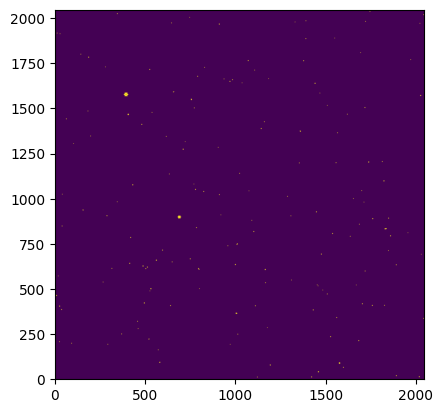

In [19]:
# Show the segmentation map
plt.imshow(segment_map, origin="lower", vmin=1, vmax=2)

## Simulate spectrum of one source

Here, we show how to simulate the dispersion of only one source. In order to simulate a full WFSS observation, what we show here needs to be done for every sourece in the field. Simulating all the dispersed spectra is also a way to mask out spectra when estimating the dispersed background level during subsequent extraction and it also allows for an estimate of the amount of spectral contamination by overlapping spectra.

For this example, we choose the source at coordinates (x,y) = (405,1465) and show how to simulate its spectrum.

We first get its segmentation map ID and create a list of all pixels associated with the source in the imaging data.

In [20]:
xd, yd = 405, 1465
ID = segment_map.data[yd, xd]
print(f"Object ID is: {ID}")

Object ID is: 118


### Locate source in imaging and WFSS data

Working with the imaging mode file, create a list of coordinates for all of the source's pixels, along with their flux values (in MJy/SR).

In [21]:
ok = segment_map.data == ID
yds, xds = np.nonzero(ok)
cds = imaging_data[ok]

Show the source, as well as its segmentation map, from the imaging data. On the left we see that the source appears to be a point source. The segmentation map shows a collection of roughly 6x6 pixels that have been identified as part of this source.

Text(0.5, 1.0, 'Segmentation map')

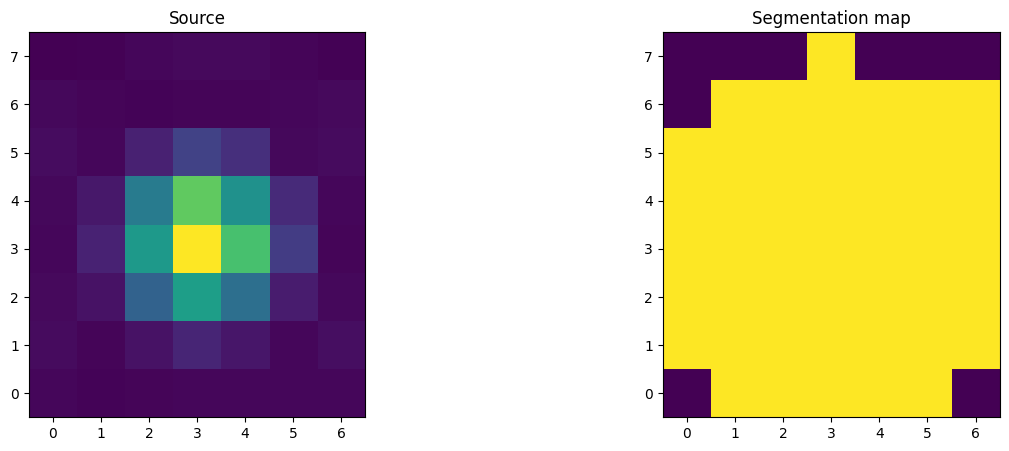

In [22]:
min_x = np.min(xds)
max_x = np.max(xds)
min_y = np.min(yds)
max_y = np.max(yds)

fig, axs = plt.subplots(1, 2, figsize=(15, 5))
axs[0].imshow(imaging_data[min_y:max_y + 1, min_x:max_x + 1], origin="lower")
axs[1].imshow(segment_map.data[min_y:max_y + 1, min_x:max_x + 1], origin="lower")
axs[0].set_title("Source")
axs[1].set_title("Segmentation map")

All the information we have for this source is within the reference frame of the imaging data. But we need to know where the flux for this source is in the WFSS observation. This is handled using the gWCS of both imaging and WFSS observations. With these, we translate the location of each source pixel in the imaging data into the corresponding pixel location in the WFSS data.

In [23]:
# Open the imaging file using the JWST datamodels, and retrieve the WCS information
imaging_wcs = datamodels.open(imaging_file)
imaging_to_world = imaging_wcs.meta.wcs.get_transform('detector', 'world')

In [24]:
# Get the WCS information associated with the WFSS file
wfss_wcs = datamodels.open(wfss_file)
wfss_to_pix = wfss_wcs.meta.wcs.get_transform('world', 'detector')

For reference, below we see the pixel coordinates in the imaging data. The pixels corresponding to the source range between x values of 402 and 408, and y values of 1461 and 1468.

Text(0, 0.5, 'Imaging rows')

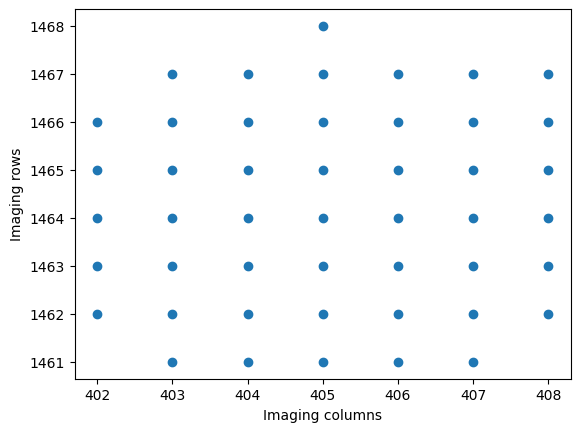

In [25]:
plt.scatter(xds, yds)
plt.xlabel("Imaging columns")
plt.ylabel("Imaging rows")

Compute the R.A. and Dec of each of the source's imaging mode input pixels

In [26]:
ras, decs = imaging_to_world(xds, yds)

Now compute the pixel coordinates of where the **undispersed** source would be in the WFSS data. In this case the gWCS requires an input wavelength and spectral order. These same values are returned by the translation function. In this case we choose a wavelength of 3.56 microns and a spectral order of 1. The pixel coordinates returned in this case are not dependent upon wavelength or spectral order, so any values can be used.

In [27]:
xs, ys, xxx, yyy = wfss_to_pix(ras, decs, 3.56, 1)

Show the pixel location of the **undispersed** source in the WFSS data. Note that the location is significantly different than that in the imaging data. In this case, the source is located between x values of 117 to 123, and y values of 1740 and 1746.

Text(0, 0.5, 'WFSS rows')

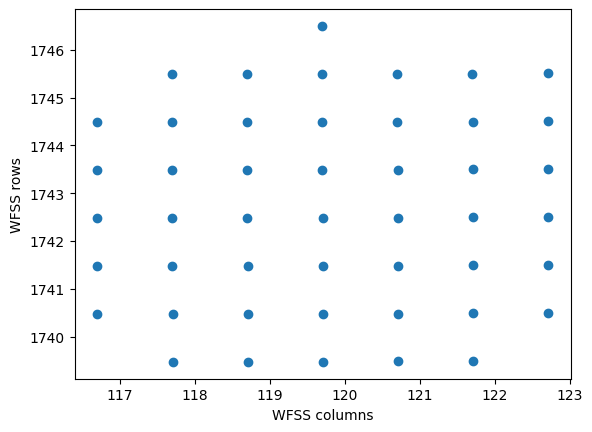

In [28]:
plt.scatter(xs, ys)
plt.xlabel("WFSS columns")
plt.ylabel("WFSS rows")

### Get wavelength information

When simulating this dispersed spectrum, we need to consider the wavelength of the light that is being dispersed. So each of the pixels above will be numericaly dispersed across a range of discrete wavelengths. 

To get the needed wavelength information, we initialize a grismconf Config object. This contains the information and polynomials describing the dispersion of the disperser as well as the corresponding inverse sensitivity curve.

In [29]:
C = grismconf.Config(wfss_file)

Loading from datamodel of jw01076109001_02101_00001_nrcalong_photomstep.fits


Show the inverse sentivity, which includes the wavelength range and shape of the sensitivity. This is defined in units of DN/s per $F_{\lambda}$ ($erg/s/cm^2/A$). The curve shows significant sensitivity between about 3.85 microns, and 5.05 microns.

Text(0, 0.5, 'DN/s per $erg/s/cm^2/A$')

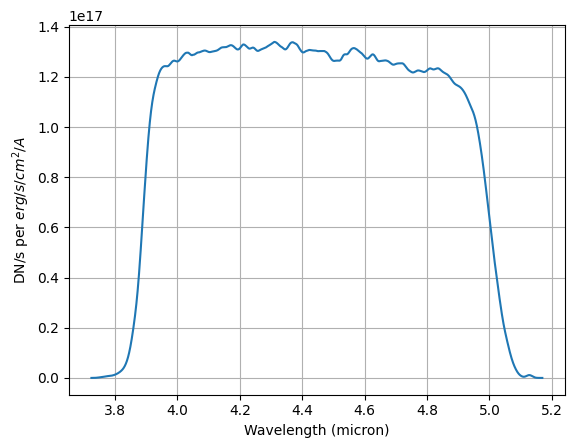

In [30]:
plt.plot(C.SENS_data["+1"][0], C.SENS_data["+1"][1])
plt.grid()
plt.xlabel("Wavelength (micron)")
plt.ylabel(r"DN/s per $erg/s/cm^2/A$")

We use the grimconf configuration object to quickly get the wavelength range that corresponds to the disperser. This is present in the WRANGE attribute.

In [31]:
wmin = C.WRANGE["+1"][0]
wmax = C.WRANGE["+1"][1]

print(f"The wavelength range to consider is {wmin} to {wmax} microns")

The wavelength range to consider is 3.7449567317962646 to 5.147075176239014 microns


Compute the dispersion in units of wavelength per pixel. Grismconf can give us the derivative of the dispersion in units of wavelength as well as in units of pixels with respect to the t parameter. Details of the $t$ parameter are given in the <a href="https://github.com/spacetelescope/jdat_notebooks/blob/main/notebooks/NIRCam/NIRCam_WFSS_Box_extraction/BoxExtraction_using_Grismconf_CRDS.ipynb">Box Extraction Notebook</a>. As noted there, $t$ is a normalized parameter, whre values of $t = 0$ and $t = 1$ correspond to the blue and red edges of a dispersed spectrum.

While the dispersion varies slightly across the area of the detector covered by a spectrum, we use the dispersion at a $t$ value of 0.5, which corresponds to the middle of the spectral range.

In [32]:
dlam = C.DDISPL("+1", 1000, 1000, 0.5) / C.DDISPX("+1", 1000, 1000, 0.5)
print(f"Dispersion is {dlam * 10000} Angstroms per pixel")

Dispersion is 9.842324883324414 Angstroms per pixel


Next, create an array of wavelength values at which the simulated spectrum will be calculated. For this, we must pick a wavelength step. Ideally this step should be smaller than the native dispersion of the grism. We therefore pick half of the dispersion value calculated above.

In [33]:
dlam = dlam / 2
lams = np.arange(wmin, wmax, dlam)

print(f"We are using {len(lams)} values of wavelength")

We are using 2850 values of wavelength


In [34]:
print(f'First and last elements of the wavelength array: {"%.5f" % lams[0]} microns, {"%.5f" % lams[-1]} microns')

First and last elements of the wavelength array: 3.74496 microns, 5.14700 microns


### Simulate the dispersion of a single pixel

With the wavelength information in hand, we can create a simulated dispersion of each object pixel.

Below, we show the process for a single pixel. We choose a pixel relatively close to the center of the source.

In [35]:
i = 22
print(f"Use pixel (x, y) = ({xs[i]}, {ys[i]}) for single pixel dispersion")

Use pixel (x, y) = (119.70338396470152, 1742.4872669791241) for single pixel dispersion


We start by computing the $t$ values corresponding to the wavelengths (lams) we are considering. Refer to the Box Extraction notenook for additional background details on the $t$ value.

In [36]:
ts = C.INVDISPL("+1", xs[i], ys[i], lams)

Next, we create an array of polygons representing the locations of the dispersed signal coming from our selected input pixel.

The cell below computes the array of coordinates, in the WFSS observation, of the bottom left corner of our pixel.

In [37]:
xgsA = C.DISPX("+1", xs[i], ys[i], ts) + xs[i]
ygsA = C.DISPY("+1", xs[i], ys[i], ts) + ys[i]

The following three cells compute the locations of the other three corners:

In [38]:
xgsB = C.DISPX("+1", xs[i] + 1, ys[i], ts) + xs[i] + 1
ygsB = C.DISPY("+1", xs[i] + 1, ys[i], ts) + ys[i]

In [39]:
xgsC = C.DISPX("+1", xs[i] + 1, ys[i] + 1, ts) + xs[i] + 1
ygsC = C.DISPY("+1", xs[i] + 1, ys[i] + 1, ts) + ys[i] + 1

In [40]:
xgsD = C.DISPX("+1", xs[i], ys[i] + 1, ts) + xs[i]
ygsD = C.DISPY("+1", xs[i], ys[i] + 1, ts) + ys[i] + 1

Re-organize things a little to contain a list of polygon corners, which are used by the pypolyclip module to compute their overlap with the pixel coordinates of the WFSS observation. While were are looking at a single input source pixel, we are computing this at many different wavelength values so the resultant is a list of many pixels/polygons to project onto our WFSS rectilinear pixel grid.

In [41]:
pxs = [[xgsA[ii], xgsB[ii], xgsC[ii], xgsD[ii]] for ii in range(len(xgsA))]

In [42]:
pys = [[ygsA[ii], ygsB[ii], ygsC[ii], ygsD[ii]] for ii in range(len(ygsA))]

Below we create a figure showing the resulting locations of dispersed pixels. We dispersed the single input pixel using an array of wavelengths that is oversampled by a factor of 2 relative to the native dispersion of the grism. That wavelength array is translated into an array of pixel positions which overlay the WFSS detector grid. 

For clarity, we zoom in on a 40 pixel wide area in the dispersion direction. This shows that our single imaging mode pixel will be dispersed along a nearly horizontal line (seen as the rainbow colored boxes) in this area. Zooming out on this plot, by changing the xlim values in the cell below, will show the entire set of pixels corresponding to the dispersed input pixel. For consistency, we show similar 40 pixel wide plots for the other figures in the next two sections.

  0%|          | 0/2850 [00:00<?, ?it/s]

 15%|█▍        | 416/2850 [00:00<00:00, 4152.04it/s]

 29%|██▉       | 832/2850 [00:00<00:00, 2214.47it/s]

 43%|████▎     | 1237/2850 [00:00<00:00, 2779.75it/s]

 58%|█████▊    | 1652/2850 [00:00<00:00, 3198.97it/s]

 73%|███████▎  | 2068/2850 [00:00<00:00, 3489.19it/s]

 86%|████████▌ | 2451/2850 [00:00<00:00, 2336.77it/s]

100%|██████████| 2850/2850 [00:01<00:00, 2785.15it/s]

Text(0, 0.5, 'Cross ispersion coordinate (pixel)')

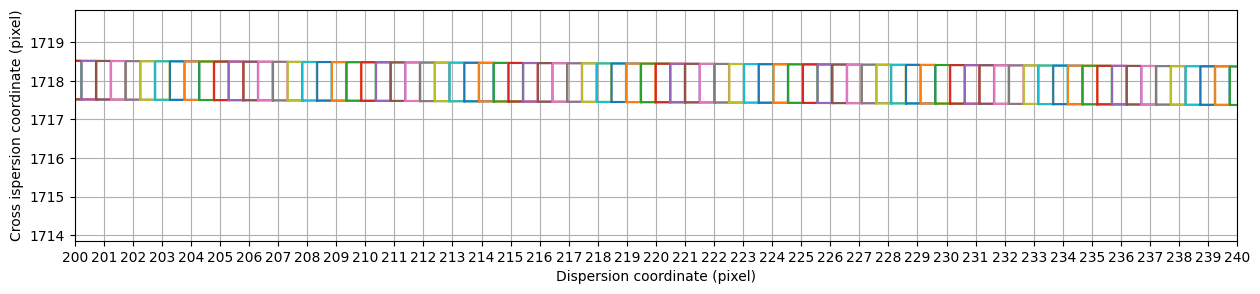

In [43]:
fig, ax = plt.subplots(1, 1, figsize=(15, 3))
for i in tqdm.tqdm(range(len(pxs))):
    tx = pxs[i]
    tx.append(pxs[i][0])
    ty = pys[i]
    ty.append(pys[i][0])
    plt.plot(tx, ty)

plt.xticks(range(0, len(pxs)))

plt.xlim(200, 240)  # change to (0, 700) to see the entire spectrum)
plt.xlabel("WFSS columns")
plt.ylabel("WFSS Rows")
plt.grid()
plt.xlabel("Dispersion coordinate (pixel)")
plt.ylabel("Cross ispersion coordinate (pixel)")

We can now use the pypolyclip.clip_multi to compute how much of each dispersed pixel (colored boxes above) falls onto each pixel in the WFSS image pixel grid (shown as the gray grid above). Details about this is available on the <A HREF="https://github.com/spacetelescope/pypolyclip">pypolyclip page</A>.

In [44]:
xc, yc, area, slices = clip_multi(pxs, pys, [2048, 2048])

In the following section, we will repeat this workflow on all pixels, and use the area information to scale the flux values for all output pixels.

### Disperse all the pixels for our source

Note that the figure above shows a single source pixel being dispersed. For a full source, each of the input source pixels should be similarly dispersed, resulting in multiple dispersed pixels contributing to the final counts in each of the detector pixels in the WFSS image. We will also need to compute and attribute the proper flux, in DN/s, to each of the WFSS detector pixels from each input pixel. This is done below for our selected object.

We must keep track of all the information such as the wavelength and fraction of the original imaging pixel flux that falls onto the WFSS simulated pixel array for each imaging pixel.

In [45]:
xcs = []
ycs = []
alams = []
flams = []

all_pxs = []
all_pys = []
all_flams = []
all_counts = []

# Loop over the input source pixels in the WFSS reference frame.
for i in tqdm.tqdm(range(len(xs))):
    # Use the imaging flux in each of these pixels to compute the input DN/s and flam units
    counts = cds[i]
    flam = counts * PHOTFLAM

    # Disperse this pixel using len(lams) wavelength. This results in len(lams) projected
    # pixels contributing to the final WFSS data
    ts = C.INVDISPL("+1", xs[i], ys[i], lams)
    xgsA = C.DISPX("+1", xs[i], ys[i], ts) + xs[i]
    ygsA = C.DISPY("+1", xs[i], ys[i], ts) + ys[i]
    xgsB = C.DISPX("+1", xs[i] + 1, ys[i], ts) + xs[i] + 1
    ygsB = C.DISPY("+1", xs[i] + 1, ys[i], ts) + ys[i]
    xgsC = C.DISPX("+1", xs[i] + 1, ys[i] + 1, ts) + xs[i] + 1
    ygsC = C.DISPY("+1", xs[i] + 1, ys[i] + 1, ts) + ys[i] + 1
    xgsD = C.DISPX("+1", xs[i], ys[i]+1, ts) + xs[i]
    ygsD = C.DISPY("+1", xs[i], ys[i]+1, ts) + ys[i] + 1

    # Use the corners of the dispersed pixels, and compute the WFSS pixels which they
    # overlap, and by how much
    pxs = [[xgsA[ii], xgsB[ii], xgsC[ii], xgsD[ii]] for ii in range(len(xgsA))]
    pys = [[ygsA[ii], ygsB[ii], ygsC[ii], ygsD[ii]] for ii in range(len(ygsA))]
    xc, yc, area, slices = clip_multi(pxs, pys, [2048, 2048])

    # Book keeping to track the wavelength of each of the areas being projected into
    # the WFSS pixel grid
    tlams = np.zeros(len(xc))
    for i in range(len(slices)):
        tlams[slices[i]] = lams[i]

    # Store the flux, wavelength, and where they should end up on the WFSS pixel grid.
    # Note the values in xcs and ycs are not unique
    xcs.extend(xc.tolist())
    ycs.extend(yc.tolist())
    flams.extend((flam * area).tolist())
    alams.extend(tlams.tolist())

    # Save for plotting later. Only used for plot below.
    all_pxs.append(pxs)
    all_pys.append(pys)
    all_flams.append(flam)
    all_counts.append(flam * C.SENS["+1"](tlams) * dlam * 10000)

  0%|          | 0/47 [00:00<?, ?it/s]

  2%|▏         | 1/47 [00:00<00:05,  8.51it/s]

  4%|▍         | 2/47 [00:00<00:05,  8.56it/s]

  6%|▋         | 3/47 [00:00<00:05,  8.59it/s]

  9%|▊         | 4/47 [00:00<00:04,  8.63it/s]

 11%|█         | 5/47 [00:00<00:04,  8.52it/s]

 13%|█▎        | 6/47 [00:00<00:04,  8.60it/s]

 15%|█▍        | 7/47 [00:00<00:04,  8.64it/s]

 17%|█▋        | 8/47 [00:00<00:04,  8.65it/s]

 19%|█▉        | 9/47 [00:01<00:04,  8.63it/s]

 21%|██▏       | 10/47 [00:01<00:04,  8.64it/s]

 23%|██▎       | 11/47 [00:01<00:04,  8.63it/s]

 26%|██▌       | 12/47 [00:01<00:04,  8.64it/s]

 28%|██▊       | 13/47 [00:01<00:03,  8.68it/s]

 30%|██▉       | 14/47 [00:01<00:03,  8.71it/s]

 32%|███▏      | 15/47 [00:01<00:03,  8.70it/s]

 34%|███▍      | 16/47 [00:01<00:03,  8.69it/s]

 36%|███▌      | 17/47 [00:01<00:03,  8.70it/s]

 38%|███▊      | 18/47 [00:02<00:06,  4.81it/s]

 40%|████      | 19/47 [00:02<00:05,  5.55it/s]

 43%|████▎     | 20/47 [00:02<00:04,  6.22it/s]

 45%|████▍     | 21/47 [00:02<00:03,  6.80it/s]

 47%|████▋     | 22/47 [00:02<00:03,  7.28it/s]

 49%|████▉     | 23/47 [00:02<00:03,  7.63it/s]

 51%|█████     | 24/47 [00:03<00:02,  7.90it/s]

 53%|█████▎    | 25/47 [00:03<00:02,  8.10it/s]

 55%|█████▌    | 26/47 [00:03<00:02,  8.26it/s]

 57%|█████▋    | 27/47 [00:03<00:02,  8.39it/s]

 60%|█████▉    | 28/47 [00:03<00:02,  8.47it/s]

 62%|██████▏   | 29/47 [00:03<00:02,  8.51it/s]

 64%|██████▍   | 30/47 [00:03<00:01,  8.57it/s]

 66%|██████▌   | 31/47 [00:03<00:01,  8.60it/s]

 68%|██████▊   | 32/47 [00:04<00:01,  8.62it/s]

 70%|███████   | 33/47 [00:04<00:01,  8.61it/s]

 72%|███████▏  | 34/47 [00:04<00:01,  8.61it/s]

 74%|███████▍  | 35/47 [00:04<00:01,  8.62it/s]

 77%|███████▋  | 36/47 [00:04<00:01,  8.62it/s]

 79%|███████▊  | 37/47 [00:04<00:01,  8.61it/s]

 81%|████████  | 38/47 [00:04<00:01,  8.63it/s]

 83%|████████▎ | 39/47 [00:04<00:00,  8.63it/s]

 85%|████████▌ | 40/47 [00:04<00:00,  8.64it/s]

 87%|████████▋ | 41/47 [00:05<00:00,  8.64it/s]

 89%|████████▉ | 42/47 [00:05<00:00,  8.64it/s]

 91%|█████████▏| 43/47 [00:05<00:00,  8.61it/s]

 94%|█████████▎| 44/47 [00:05<00:00,  8.59it/s]

 96%|█████████▌| 45/47 [00:05<00:00,  4.65it/s]

 98%|█████████▊| 46/47 [00:05<00:00,  5.41it/s]

100%|██████████| 47/47 [00:06<00:00,  6.11it/s]

100%|██████████| 47/47 [00:06<00:00,  7.74it/s]

At this point, we have a list of WFSS pixels (xcs, ycs), the flux falling on these pixels (flams, in $F_{\lambda}$ units), and the wavelength of the light contained in them (alams).
In our simulation, we do not want to project flux units but rather DN/s, so we convert the input flams values into DN/s (using the reverse relation we used in the Box Extraction notebook when we performed the inverse operation to convert extracted DN/s into $F_{\lambda}$ flux units)

In [46]:
# Note: the factor of 10000 below accounts for dlam being in microns, while we
# want Angstroms since the inverse sensitivity is defined per Angstrom.
s = C.SENS["+1"](alams)
counts = flams * s * dlam * 10000

In [47]:
print(f"There are {len(counts)} dispersed bits of pixels to combine into a final WFSS pixel grid")

There are 507649 dispersed bits of pixels to combine into a final WFSS pixel grid


We now have a large list of DN/s values and where they should be added onto our simulated WFSS observationn in order to simulate the full dispersed spectrum of our source.
There are duplicate entries in the (xcs,ycs) coordinate list as different wavelengths get mixed by the object's "self-contamination".

The following plot shows the dispersed input pixels, using blue outlines, projected onto the final WFSS pixels, which are shown as the gray grid. The dispersed pixels are shaded in black proportionally to their flux (in DN/s).

  0%|          | 0/47 [00:00<?, ?it/s]

  2%|▏         | 1/47 [00:02<01:58,  2.57s/it]

  4%|▍         | 2/47 [00:05<01:58,  2.64s/it]

  6%|▋         | 3/47 [00:07<01:44,  2.38s/it]

  9%|▊         | 4/47 [00:10<01:51,  2.59s/it]

 11%|█         | 5/47 [00:13<01:55,  2.75s/it]

 13%|█▎        | 6/47 [00:15<01:42,  2.50s/it]

 15%|█▍        | 7/47 [00:18<01:50,  2.76s/it]

 17%|█▋        | 8/47 [00:20<01:38,  2.52s/it]

 19%|█▉        | 9/47 [00:22<01:30,  2.37s/it]

 21%|██▏       | 10/47 [00:26<01:41,  2.75s/it]

 23%|██▎       | 11/47 [00:28<01:31,  2.53s/it]

 26%|██▌       | 12/47 [00:30<01:23,  2.39s/it]

 28%|██▊       | 13/47 [00:34<01:38,  2.89s/it]

 30%|██▉       | 14/47 [00:36<01:26,  2.63s/it]

 32%|███▏      | 15/47 [00:38<01:18,  2.45s/it]

 34%|███▍      | 16/47 [00:40<01:12,  2.32s/it]

 36%|███▌      | 17/47 [00:45<01:29,  3.00s/it]

 38%|███▊      | 18/47 [00:47<01:18,  2.71s/it]

 40%|████      | 19/47 [00:49<01:10,  2.51s/it]

 43%|████▎     | 20/47 [00:51<01:03,  2.37s/it]

 45%|████▍     | 21/47 [00:53<00:59,  2.27s/it]

 47%|████▋     | 22/47 [00:58<01:18,  3.15s/it]

 49%|████▉     | 23/47 [01:00<01:07,  2.83s/it]

 51%|█████     | 24/47 [01:02<00:59,  2.60s/it]

 53%|█████▎    | 25/47 [01:04<00:53,  2.44s/it]

 55%|█████▌    | 26/47 [01:06<00:48,  2.33s/it]

 57%|█████▋    | 27/47 [01:08<00:45,  2.25s/it]

 60%|█████▉    | 28/47 [01:14<01:04,  3.41s/it]

 62%|██████▏   | 29/47 [01:16<00:54,  3.02s/it]

 64%|██████▍   | 30/47 [01:19<00:46,  2.74s/it]

 66%|██████▌   | 31/47 [01:21<00:40,  2.55s/it]

 68%|██████▊   | 32/47 [01:23<00:36,  2.41s/it]

 70%|███████   | 33/47 [01:25<00:32,  2.31s/it]

 72%|███████▏  | 34/47 [01:27<00:29,  2.25s/it]

 74%|███████▍  | 35/47 [01:29<00:26,  2.21s/it]

 77%|███████▋  | 36/47 [01:36<00:40,  3.73s/it]

 79%|███████▊  | 37/47 [01:38<00:32,  3.23s/it]

 81%|████████  | 38/47 [01:40<00:26,  2.89s/it]

 83%|████████▎ | 39/47 [01:43<00:21,  2.65s/it]

 85%|████████▌ | 40/47 [01:45<00:17,  2.50s/it]

 87%|████████▋ | 41/47 [01:47<00:14,  2.39s/it]

 89%|████████▉ | 42/47 [01:49<00:11,  2.31s/it]

 91%|█████████▏| 43/47 [01:51<00:09,  2.25s/it]

 94%|█████████▎| 44/47 [01:53<00:06,  2.21s/it]

 96%|█████████▌| 45/47 [02:02<00:08,  4.08s/it]

 98%|█████████▊| 46/47 [02:04<00:03,  3.49s/it]

100%|██████████| 47/47 [02:06<00:00,  3.08s/it]

100%|██████████| 47/47 [02:06<00:00,  2.69s/it]

Text(0, 0.5, 'Cross dispersion coordinate (pixel)')

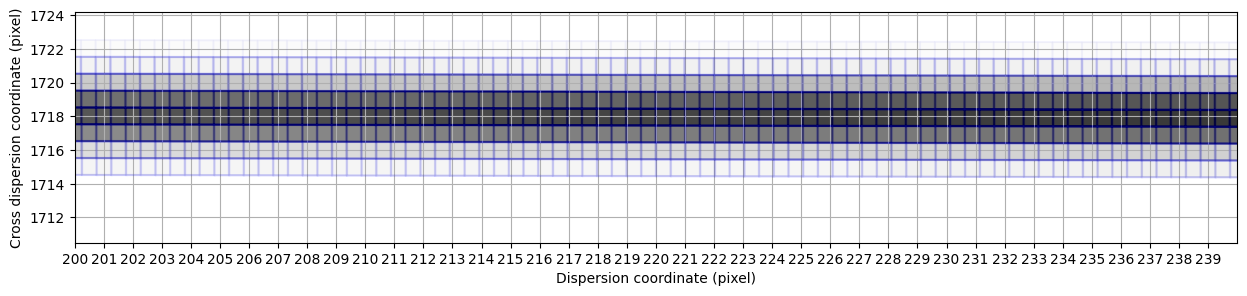

In [48]:
fig, ax = plt.subplots(1, 1, figsize=(15, 3))
for i in tqdm.tqdm(range(len(all_pxs))):
    for j in range(len(all_pxs[i])):
        
        tx = all_pxs[i][j][:]
        tx.append(tx[0])
        ty = all_pys[i][j][:]
        ty.append(ty[0])
        plt.plot(tx, ty, color='b', alpha=0.02)
        c = all_counts[i]
        c[c < 0] = 0
        plt.fill(tx, ty, color='k', alpha=c[j])
plt.grid()
plt.xlim(200, 240)  # change to (0, 700) to see the entire spectrum)
plt.xticks(range(200, 240))
plt.xlabel("Dispersion coordinate (pixel)")
plt.ylabel("Cross dispersion coordinate (pixel)")

To quickly combine all of these counts at each of their WFSS pixel location, we can use scipy.coo_matrix which is fast and efficient:

In [49]:
xcs = np.array(xcs)
ycs = np.array(ycs)

# Ignore counts and coordinates that are outside of the detector
ok = (xcs >= 0) & (xcs < 2048) & (ycs >= 0) & (ycs < 2048) 
simulated = coo_matrix((counts[ok], (ycs[ok], xcs[ok])), shape=(2048, 2048)).toarray()

Show the resulting 2D simulated spectrum for this source. We see a nearly horizontal trace across the field of view. Increasing the x range of the plot to (0, 700) will reveal the full trace.

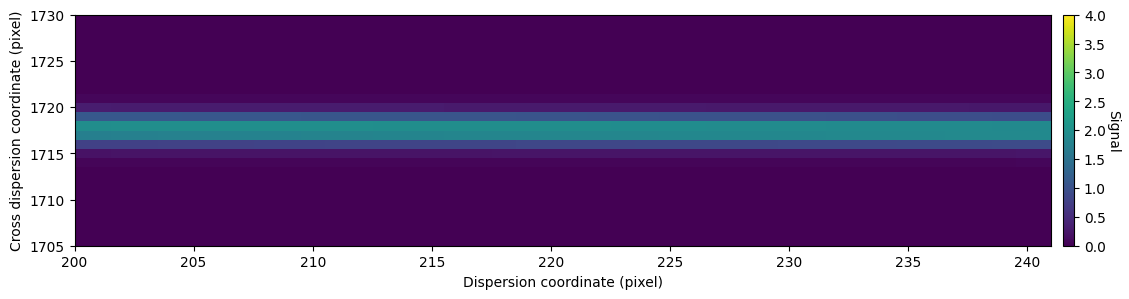

In [50]:
# Change xlim to (0, 700) to see the entire spectrum)
show_2d_spec(simulated, xlim=(200, 241), ylim=(1705, 1730), vmin=0, vmax=4)

Show the real data at the same scale. This trace also appears as a nearly horizontal line. The signal level in the real data is slightly higher than that of the simulated data.

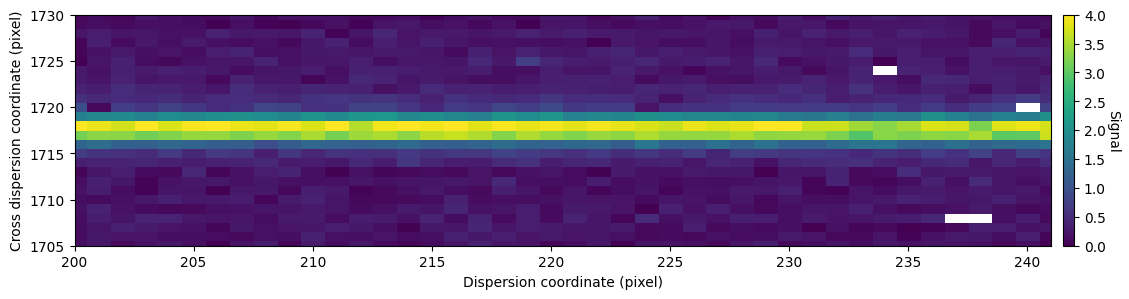

In [51]:
# Change xlim to (0, 700) to see the entire spectrum)
show_2d_spec(wfss_data, xlim=(200, 241), ylim=(1705, 1730), vmin=0, vmax=4)

A good way to check our simulated image is to subtract the simulation from our data. The figure below shows the simulated minus real difference image. The difference in peak level of the trace is visible. The alignment of the simulated and real traces is also apparent as the width of the difference is constant from left to right.

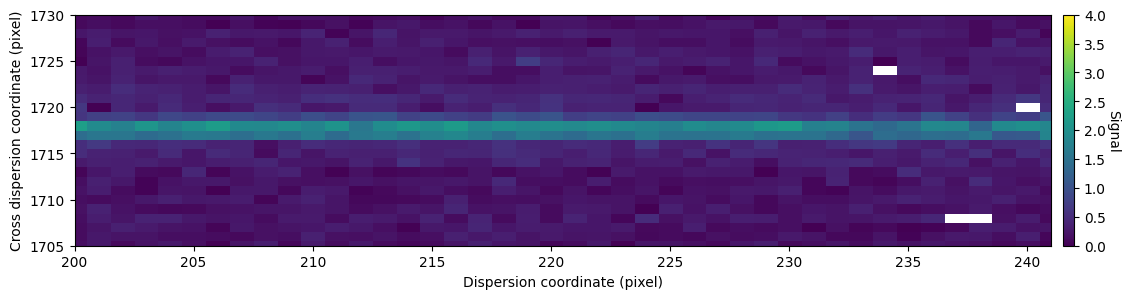

In [52]:
# Change xlim to (0, 700) to see the entire spectrum)
show_2d_spec(wfss_data - simulated, xlim=(200, 241), ylim=(1705, 1730), vmin=0, vmax=4)

Sum the simulated spectrum and also the real data in the dispersion direction to check if the trace profiles are well aligned. The figure below shows the summed real data (orange) and simulation (blue line). The left/right alignment of the two peaks shows that the location of the simulated trace is very close to that of the real trace.

Text(0.5, 0, 'Cross dispersion coordinate (pixel)')

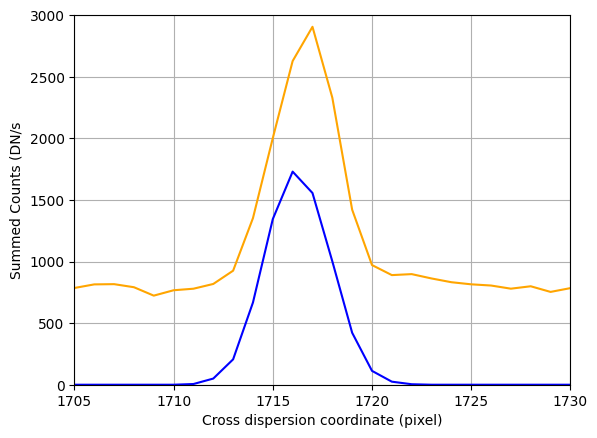

In [53]:
plt.plot(np.nansum(simulated, axis=-1), color='blue')
plt.plot(np.nansum(wfss_data, axis=-1), color='orange')
plt.xlim(1705, 1730)
plt.ylim(0, 3000)
plt.grid()
plt.ylabel("Summed Counts (DN/s")
plt.xlabel("Cross dispersion coordinate (pixel)")

While the simulation appears to be astrometrically correct, we have not accounted for the dispersed background, causing the signal in the simulation to be too low.
This should be done using a model of the dispersed background but here, for simplicity and because we are looking at a region where we know the dispersed background is relatively featureless and flat, we can just use the simulation to create  a mask and then compute the background level per pixel.
Below we mask pixels in the simulated image above a signal level of 0.001 DN/s. This masks the trace. The remaining pixels, visible below in black, will be used to calculate the background level.

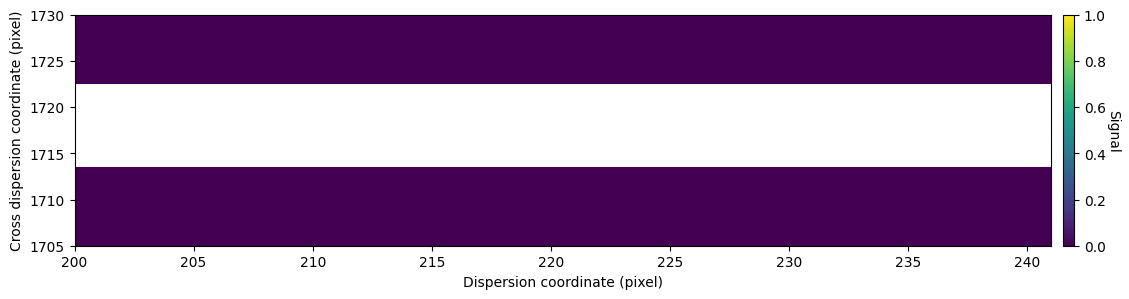

In [54]:
# Masked pixels, set to NaN, appear white in the display
mask = simulated > 0.0001
tmp = simulated * 1.
tmp[mask] = np.nan
# Change xlim to (0, 700) to see the entire spectrum)
show_2d_spec(tmp, xlim=(200, 241), ylim=(1705, 1730), vmin=0, vmax=1)

Compute the median dispersed background level.

In [55]:
bck_level = np.nanmedian(wfss_data[~mask])
print(f"Background extimated to be {bck_level} DN/s per pixel")

Background extimated to be 0.4018511176109314 DN/s per pixel


Now plot the collapsed simulated data (blue) and background-subtracted real data (orange). The well-aligned peaks show more clearly that the simulated and real traces are well-aligned. The peak of the simulated data is lower than that of the real data, showing that the simulation slightly under-estimates the signal in the real trace.

Text(0.5, 0, 'Cross dispersion coordinate (pixel)')

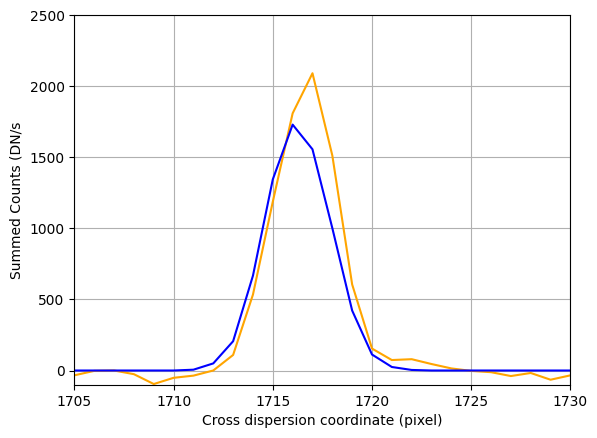

In [56]:
plt.plot(np.nansum(wfss_data - bck_level, axis=-1), color='orange')
plt.xlim(1705, 1730)
plt.ylim(-100, 2500)
plt.plot(np.nansum(simulated, axis=-1), color='blue')
plt.grid()
plt.ylabel("Summed Counts (DN/s")
plt.xlabel("Cross dispersion coordinate (pixel)")

After subtracting the background, the simulated spectrum is a good match to the real data. The 2D simulated spectrum can now be used to subtract contamination of overlapping spectra, as well as to mask dispersed spectral traces when trying to estimate the background.

<img style="float: right;" src="https://raw.githubusercontent.com/spacetelescope/notebooks/master/assets/stsci_pri_combo_mark_horizonal_white_bkgd.png" alt="Space Telescope Logo" width="200px"/>